In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb  # Corrected import

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical

C:\Users\asus\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = './archive/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = './archive/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


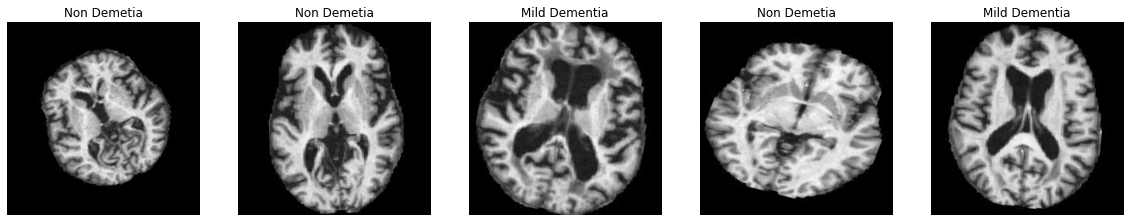

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [6]:
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [1]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

NameError: name 'Sequential' is not defined

In [9]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [10]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [11]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [12]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
33/33 [==============================] - ETA: 0s - loss: 1.3743 - auc: 0.7785
Epoch 00001: val_auc improved from -inf to 0.61004, saving model to ./best_weights.hdf5
33/33 [==============================] - 67s 2s/step - loss: 1.3743 - auc: 0.7785 - val_loss: 1.7313 - val_auc: 0.6100
Epoch 2/500
33/33 [==============================] - ETA: 0s - loss: 1.1647 - auc: 0.8136
Epoch 00002: val_auc improved from 0.61004 to 0.67029, saving model to ./best_weights.hdf5
33/33 [==============================] - 57s 2s/step - loss: 1.1647 - auc: 0.8136 - val_loss: 1.3862 - val_auc: 0.6703
Epoch 3/500
33/33 [==============================] - ETA: 0s - loss: 1.0259 - auc: 0.8342
Epoch 00003: val_auc improved from 0.67029 to 0.69523, saving model to ./best_weights.hdf5
33/33 [==============================] - 57s 2s/step - loss: 1.0259 - auc: 0.8342 - val_loss: 1.2798 - val_auc: 0.6952
Epoch 4/500
33/33 [==============================] - ETA: 0s - loss: 1.0064 - auc: 0.8409
Epoch 00004: 

Epoch 31/500
33/33 [==============================] - ETA: 0s - loss: 0.6821 - auc: 0.9141
Epoch 00031: val_auc did not improve from 0.85256
33/33 [==============================] - 56s 2s/step - loss: 0.6821 - auc: 0.9141 - val_loss: 0.9999 - val_auc: 0.8373
Epoch 32/500
33/33 [==============================] - ETA: 0s - loss: 0.6620 - auc: 0.9198
Epoch 00032: val_auc did not improve from 0.85256
33/33 [==============================] - 55s 2s/step - loss: 0.6620 - auc: 0.9198 - val_loss: 1.1021 - val_auc: 0.8183
Epoch 33/500
33/33 [==============================] - ETA: 0s - loss: 0.6732 - auc: 0.9165
Epoch 00033: val_auc did not improve from 0.85256
33/33 [==============================] - 56s 2s/step - loss: 0.6732 - auc: 0.9165 - val_loss: 1.1269 - val_auc: 0.8394
Epoch 34/500
33/33 [==============================] - ETA: 0s - loss: 0.6512 - auc: 0.9225
Epoch 00034: val_auc did not improve from 0.85256
33/33 [==============================] - 55s 2s/step - loss: 0.6512 - auc: 0.92

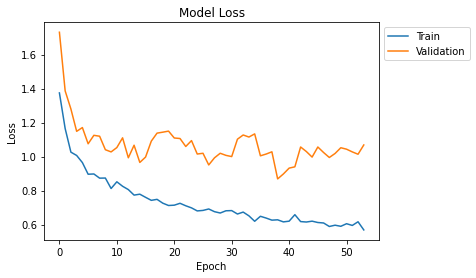

In [14]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

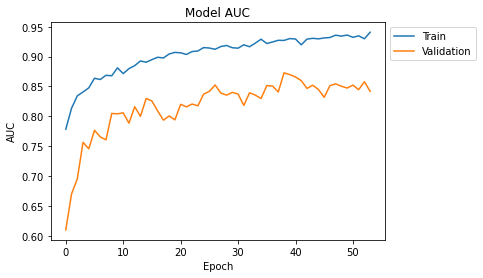

In [15]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()